<a href="https://colab.research.google.com/github/Sasigaya3/weapon-detection/blob/main/gundetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy matplotlib opencv-python pillow albumentations torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
!pip install opendatasets
import opendatasets as od

# Replace the URL below with the URL of the dataset you want to download
dataset_url = 'https://www.kaggle.com/datasets/trainingdatapro/people-with-guns-segmentation-and-detection/data'

# Download the dataset
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hfgdgfc
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/people-with-guns-segmentation-and-detection


100%|██████████| 66.4M/66.4M [00:00<00:00, 1.39GB/s]

In [ ]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob; from PIL import ImageFile
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
ImageFile.LOAD_TRUNCATED_IMAGES = True

class CustomSegmentationDataset(Dataset):

    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/images/*"))
        self.gt_paths = sorted(glob(f"{root}/labels/*"))
        self.transformations = transformations
        self.n_cls = 2

        assert len(self.im_paths) == len(self.gt_paths)

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])

        if self.transformations: im, gt = self.apply_transformations(im, gt)
        # print(torch.unique((gt > 128).int()))
        # print(gt.shape)
        return im, (gt > 90).int()

    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path, gt_path)

    def read_im(self, im_path, gt_path): return np.array(Image.open(im_path).convert("RGB")), np.array(Image.open(gt_path).convert("L"))

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.8, 0.1, 0.1], ns = 4):

    assert sum(split) == 1., "Sum of the split must be exactly 1"

    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)

    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, test_dl, n_cls
root = "/content/people-with-guns-segmentation-and-detection"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 2)


There are 8 number of images in the train set
There are 1 number of images in the validation set
There are 2 number of images in the test set



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


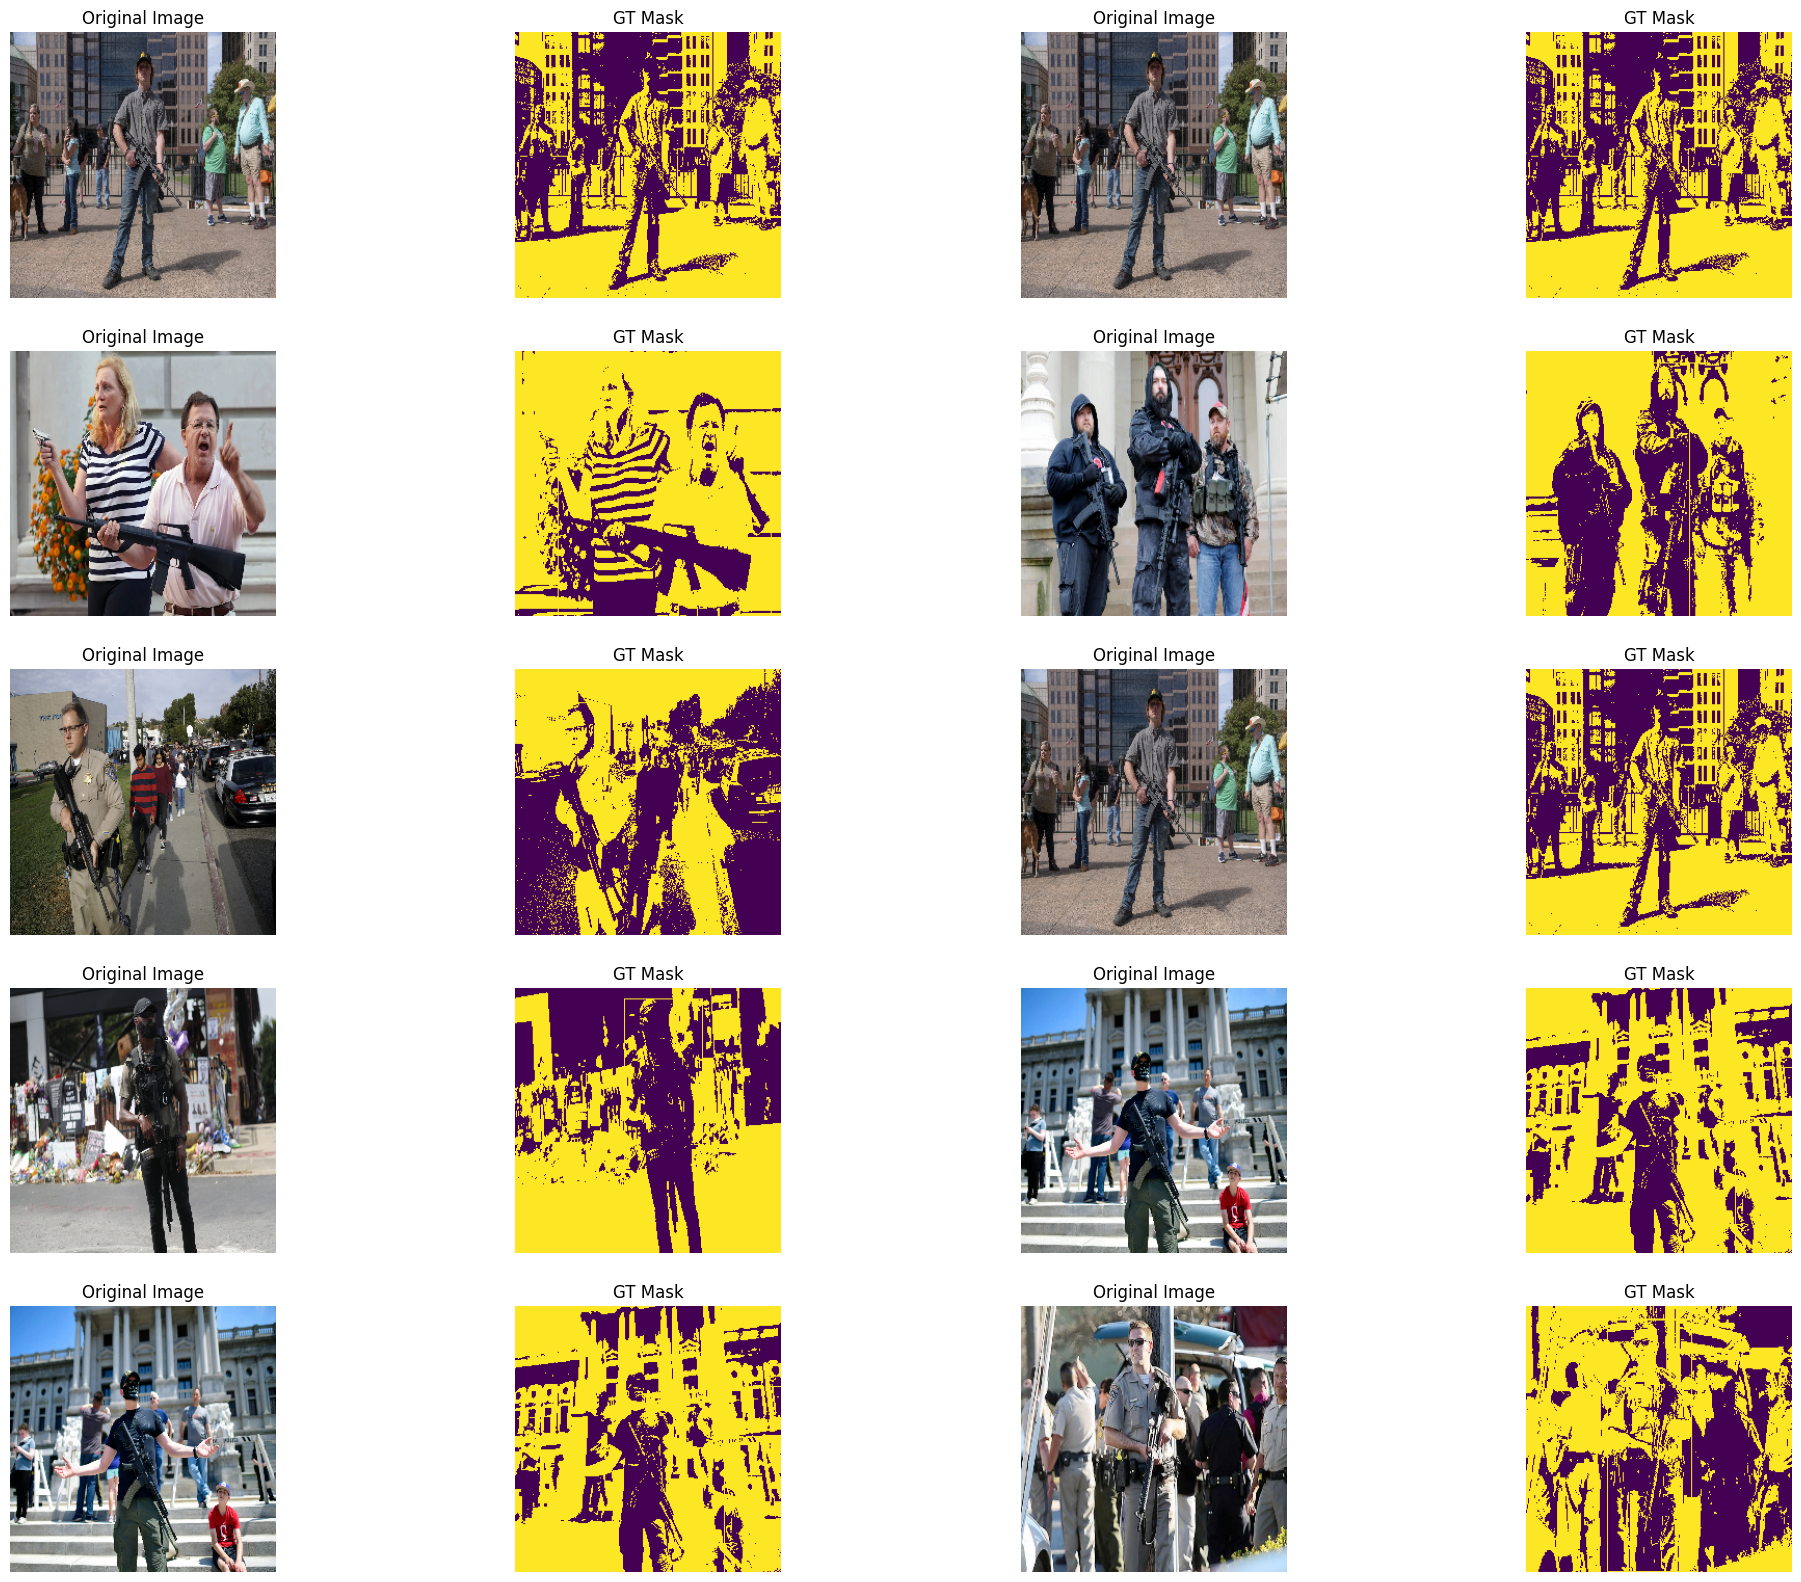

In [ ]:
import random
from torchvision import transforms as tfs

def tn_2_np(t):
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])

    rgb = True if len(t) == 3 else False

    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break
        im, gt = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im)

        # Second Plot
        count = plot(rows, cols, count, im = gt / 255, gt = True, title = "GT Mask")

visualize(tr_dl.dataset, n_ims = 20)

In [ ]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp, time
from tqdm import tqdm
from torch.nn import functional as F

model = smp.DeepLabV3Plus(classes = n_cls)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

        self.pred, self.gt = torch.argmax(pred, dim = 1), gt.squeeze(1) # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):

                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                else:

                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self): return self.loss_fn(self.pred_, self.gt.long())

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.005, save_path = "saved_models"):

    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):

            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()

            tr_iou_ += met.mIoU()

            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()


        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

        if best_loss > (val_loss_ + threshold):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:
            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = "guns")

NameError: name 'torch' is not defined

In [ ]:
class Plot():

    def __init__(self, res):

        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")


    def plot(self, metric, label): plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):

        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)

Plot(history)

NameError: name 'history' is not defined

In [ ]:
def inference(dl, model, device, n_ims = 15):

    cols = n_ims // 3; rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)

    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break

        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

# Modify the torch.load call to set weights_only=False
model = torch.load("/content/saved_models/guns_best_model.pt", weights_only=False)
inference(test_dl, model = model, device = device)

NameError: name 'torch' is not defined

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot(cols, rows, count, im, gt=False, title=""):
    plt.subplot(rows, cols, count)
    if gt:
        plt.imshow(im.cpu(), cmap="gray")
    else:
        plt.imshow(im[0].cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis("off")
    return count + 1

def inference(dl, model, device, n_ims=15):
    cols = n_ims // 3
    rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    total_pixels = 0
    correct_pixels = 0

    model.eval()  # Ensure model is in evaluation mode

    for idx, data in enumerate(dl):
        im, gt = data
        im, gt = im.to(device), gt.to(device)

        # Get predicted mask
        with torch.no_grad():
            pred = torch.argmax(model(im), dim=1)

        ims.append(im.cpu())
        gts.append(gt.cpu())
        preds.append(pred.cpu())

        # Accuracy calculation
        correct_pixels += (pred == gt).sum().item()
        total_pixels += torch.numel(gt)

        if len(ims) >= cols:
            break  # only process n_ims images for display

    # Plotting
    plt.figure(figsize=(25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols:
            break

        count = plot(cols, rows, count, im)
        count = plot(cols, rows, count, im=gt.squeeze(0), gt=True, title="Ground Truth")
        count = plot(cols, rows, count, im=pred.squeeze(0), gt=True, title="Predicted Mask")

    # Accuracy output
    accuracy = 100.0 * correct_pixels / total_pixels
    print(f"Pixel-wise Accuracy: {accuracy:.2f}%")


In [ ]:
model = torch.load("/content/sample_data", weights_only=False)
inference(test_dl, model=model, device=device)


IsADirectoryError: [Errno 21] Is a directory: '/content/sample_data'